In [1]:
# import
import pandas as pds
#import string
import numpy as np

#for machine Learning - classification 
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
#
# for visuaiization
#import seaborn as sns
import matplotlib.pyplot as plt

#for NLP
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

import nltk

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
import string
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.backend import clear_session


In [2]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            
            if word in word_index:
               
            
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)

    return embedding_matrix


In [3]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [4]:
# Lecture du fichiern et création de la data frame.
#  Nom des colonnes: tweet_id, sentiment, author, content
#  Liste des sentiments : 'empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
#    'hate' 'happiness' 'boredom' 'relief' 'anger'

data_emo2= pds.read_csv('./datas/text_emotion.csv')
#data_emo2= pds.read_csv('./datas/text_emotion_02.csv')
#, engine= "python", encoding='utf-8', error_bad_lines=False) # POUR GOOGLE COLAB SINON ERREUR!

print("Nombre de message:",len(data_emo2))

df_count_emotion = data_emo2.groupby(['sentiment']).size().reset_index(name='compt')
print("Les émotions....:\n",df_count_emotion)

df_count_author = data_emo2.groupby(['author']).size().reset_index(name='compt')
#print(df_count_author)
print("Les auteurs par ordres décroissant du nombre de message postés:\n",
      df_count_author.sort_values(by= "compt", ascending = False).head(30))


Nombre de message: 40000
Les émotions....:
      sentiment  compt
0        anger    110
1      boredom    179
2        empty    827
3   enthusiasm    759
4          fun   1776
5    happiness   5209
6         hate   1323
7         love   3842
8      neutral   8638
9       relief   1526
10     sadness   5165
11    surprise   2187
12       worry   8459
Les auteurs par ordres décroissant du nombre de message postés:
                 author  compt
7942       MissxMarisa     23
2171      ChineseLearn     22
7668    MiDesfileNegro     19
18330       erkagarcia     19
24210         lost_dog     18
32187         tsarnick     17
6093        KimmiMcfly     15
23944      linnetwoods     15
3079           Dogbook     14
15739      cece_newnew     14
26091  mrs_mcsupergirl     14
32248       twebbstack     14
9312             Quimo     14
21495  jesssicababesss     13
17396    divxdownloads     13
24184     lopezwilfred     12
11650     TraceyHewins     12
23713        lesley007     12
11577        

In [5]:
# Tokenisation

# Création d'une colonne tokenisée
corpus=[]
for el in data_emo2.content:
    token= word_tokenize(el)
    corpus.append(token)
data_emo2['token_brut'] = pds.Series(corpus)
#print(data_emo2.token_brut.head(10))

In [6]:
data_emo2.content
# @tiffanylue à supprimer dans vocabulaire
# !! ou !!! ... indication de surprise remplacer tout les   !!, !!! par un condage
# rechercher les :) , :-) ,... remplacer par mot codé

0        @tiffanylue i know  i was listenin to bad habi...
1        Layin n bed with a headache  ughhhh...waitin o...
2                      Funeral ceremony...gloomy friday...
3                     wants to hang out with friends SOON!
4        @dannycastillo We want to trade with someone w...
                               ...                        
39995                                     @JohnLloydTaylor
39996                       Happy Mothers Day  All my love
39997    Happy Mother's Day to all the mommies out ther...
39998    @niariley WASSUP BEAUTIFUL!!! FOLLOW ME!!  PEE...
39999    @mopedronin bullet train from tokyo    the gf ...
Name: content, Length: 40000, dtype: object

In [7]:
# Création d'une colonne tokenisée sans stopwords avec ponctuation (important pour les émoticones)
stopwords=nltk.corpus.stopwords.words('english')
#stopwords.extend(exclude)

corpus=[]
for el in data_emo2.token_brut:
    token=[]
    for wd in el:
        if wd not in stopwords:
            token.append(wd)
    corpus.append(token)
data_emo2['token_sans_stopwd'] = pds.Series(corpus)



In [8]:
# À partir de la cellule précédente on ré-écrit les phrase sans stopword (utilisé par la suite 
#  avec la vectorisation)

corpus= data_emo2['token_sans_stopwd']

corpus2=[]
for el in corpus:
    ligne=''
    ligne = ' '.join(el) # Magique! 
    corpus2.append(ligne)

data_emo2['phrase_sans_stopwd'] = pds.Series(corpus2)

#print(data_emo2.phrase_sans_stopwd.head(2

In [9]:
# Lemantisation et normalisation

lemma = WordNetLemmatizer()

corpus=[]
#print(stopwords)
for el in data_emo2.token_sans_stopwd:
    token=[]
    token=[lemma.lemmatize(word.lower()) for word in el]
    corpus.append(token)

data_emo2['lemn_normal'] = pds.Series(corpus)

#data_emo2.lemn_normal.head(10)

In [10]:
"""
from sklearn.feature_extraction.text import TfidfVectorizer

choix= 1

if choix== 0:
    #vectorisation_cv = CountVectorizer(ngram_range=(1, 2))
    vectorisation_cv = CountVectorizer()

    cv= vectorisation_cv.fit_transform(data_emo2.phrase_sans_stopwd)
    feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés
    #print(feature_names[:1000])

elif choix== 1:
    vectorisation_cv= tfidf_vectorizer = TfidfVectorizer()
    cv= vectorisation_cv.fit_transform(data_emo2.phrase_sans_stopwd)
    feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés
    #print(feature_names[:1000])

X_train, X_test, y_train, y_test = train_test_split(cv, data_emo2.sentiment, test_size = 0.3,random_state=42)

print(X_train)
"""

'\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\nchoix= 1\n\nif choix== 0:\n    #vectorisation_cv = CountVectorizer(ngram_range=(1, 2))\n    vectorisation_cv = CountVectorizer()\n\n    cv= vectorisation_cv.fit_transform(data_emo2.phrase_sans_stopwd)\n    feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés\n    #print(feature_names[:1000])\n\nelif choix== 1:\n    vectorisation_cv= tfidf_vectorizer = TfidfVectorizer()\n    cv= vectorisation_cv.fit_transform(data_emo2.phrase_sans_stopwd)\n    feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés\n    #print(feature_names[:1000])\n\nX_train, X_test, y_train, y_test = train_test_split(cv, data_emo2.sentiment, test_size = 0.3,random_state=42)\n\nprint(X_train)\n'

In [14]:

X_train, X_test, y_train, y_test = train_test_split(data_emo2.token_brut, data_emo2.sentiment, test_size = 0.3,random_state=42)


num_words= 5000
tokenizer = Tokenizer(num_words= num_words, lower= False, filters= '')
tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train_token[2])
print(X_test_token[2])
print(vocab_size)

[2, 119, 43, 68, 79, 105, 68, 171, 104]
[18, 3127, 538, 501, 3171, 353, 3171, 3046, 26, 11, 42, 435, 7, 103, 1786, 14, 101, 71, 51, 1]
45994


In [15]:

maxlen= max(data_emo2.content.apply(str.split).apply(len)) # 100

X_train_ps = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_test_ps = pad_sequences(X_test_token, padding='post', maxlen=maxlen)

In [16]:
X_train_ps.shape

(28000, 34)

In [17]:

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 50)            2299700   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_2 (Dense)              (None, 13)                1313      
Total params: 2,302,623
Trainable params: 2,302,623
Non-trainable params: 0
______________________________________________

In [18]:

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [19]:
history = model.fit(X_train_ps, y_train,
                    epochs=15,
                    verbose= True,
                    validation_data=(X_test_ps, y_test),
                    batch_size=500)
loss, accuracy = model.evaluate(X_train_ps, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_ps, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Epoch 1/15
56/56 [==============================] - 2s 33ms/step - loss: 2.4823 - accuracy: 0.1620 - val_loss: 2.1768 - val_accuracy: 0.2183
Epoch 2/15
56/56 [==============================] - 2s 31ms/step - loss: 2.1645 - accuracy: 0.2294 - val_loss: 2.1351 - val_accuracy: 0.2666
Epoch 3/15
56/56 [==============================] - 2s 35ms/step - loss: 2.1149 - accuracy: 0.2638 - val_loss: 2.0673 - val_accuracy: 0.2970
Epoch 4/15
56/56 [==============================] - 2s 31ms/step - loss: 2.0169 - accuracy: 0.3177 - val_loss: 1.9771 - val_accuracy: 0.3300
Epoch 5/15
56/56 [==============================] - 2s 31ms/step - loss: 1.8898 - accuracy: 0.3614 - val_loss: 1.9393 - val_accuracy: 0.3399
Epoch 6/15
56/56 [==============================] - 2s 31ms/step - loss: 1.8169 - accuracy: 0.3856 - val_loss: 1.9361 - val_accuracy: 0.3345
Epoch 7/15
56/56 [==============================] - 2s 32ms/step - loss: 1.7456 - accuracy: 0.4062 - val_loss: 1.9461 - val_accuracy: 0.3380
Epoch 8/15
56

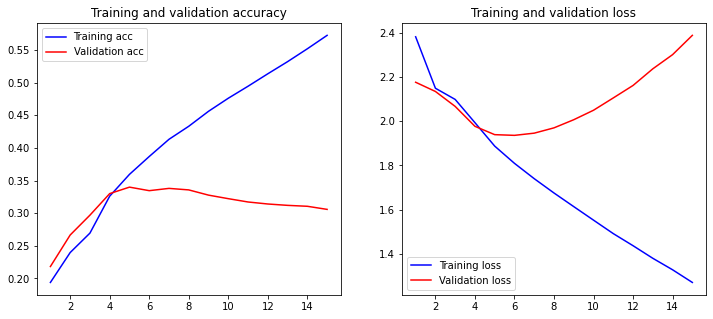

In [20]:
plot_history(history)


In [21]:
y_predicted = model.predict(X_test_ps)
accuracy = model.evaluate(X_test_ps, y_test, batch_size= 100, verbose= True)
print(y_test.shape)

120/120 [==============================] - 0s 2ms/step - loss: 2.3894 - accuracy: 0.3058
(12000,)


In [130]:
y_predicted.shape
print(y_predicted.sum())
print(y_predicted[0].sum())

12000.0
0.9999999


In [132]:
print(classification_report(y_test, y_predicted.argmax(1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00       242
           3       0.00      0.00      0.00       249
           4       0.00      0.00      0.00       513
           5       0.27      0.40      0.33      1568
           6       0.23      0.15      0.19       383
           7       0.32      0.37      0.34      1134
           8       0.35      0.42      0.38      2620
           9       0.00      0.00      0.00       515
          10       0.27      0.29      0.28      1560
          11       0.07      0.03      0.04       625
          12       0.32      0.40      0.35      2501

    accuracy                           0.31     12000
   macro avg       0.14      0.16      0.15     12000
weighted avg       0.26      0.31      0.28     12000



/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
def prediction(sms, feel=["anger", "boredom","empty","enthusiasm","fun","happiness","hate","love","neutral","relief","sadness","surprise","worry"]):
    sms_token = tokenizer.texts_to_sequences(sms)
    sms_ps = pad_sequences(sms_token, padding='post', maxlen=maxlen)
    y_predsms = model.predict(sms_ps)

    #print(y_predsms.argmax())

    return feel[y_predsms.argmax()]

sms= ["I'm in love with her"]
print(f"sms: {sms}, prediction: {prediction(sms)}")

sms= ["He is very bad, I hate him"]
print(f"sms: {sms}, prediction: {prediction(sms)}")

sms= ["It's borring"]
print(f"sms: {sms}, prediction: {prediction(sms)}")

sms= ["I hate him :) It's a joke"]
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")

sms= ["@mariamariamaria i'm sorry you aren't feeling too good, mama  I'm heading up today @ 4, i'll be calling you .."]
print('1961281804,"happiness","missvmarie"')
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")

sms= ["Licking chocolate crumbs off a Twirl wrapper like Zammo on smack"]
print('1961283943,"happiness","emohoho"')
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")

sms= ["Leaving NOLA today  Counting down the seconds 'til I start crying. Love this place so much."]
print('1961281805,"sadness","bonyay"')
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")
a=["1961282068","happiness","georgiamae31","@AnnaSaccone Seeing my friends and doing coursework  I have the weekend off work so I am happy!"]
print(a[0]," - ",a[1]," - ",a[2])
sms= [a[3]]
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")
a=[1961282376,"anger","MRajotte","Stupid red hair is too difficult on the upkeep. Re-dyed it a more manageable brown-red. Boo"]
print(a[0]," - ",a[1]," - ",a[2])
sms= [a[3]]
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")
a=[1961282406,"happiness","xSwitchBoardx","@alliemunchkin :3, Youtube loves my HD videos  well maybe."]
print(a[0]," - ",a[1]," - ",a[2])
sms= [a[3]]
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")
a=[1961282497,"hate","sleepywhale","@tylerakira - ughhh!!! have to go back there tonight"]
print(a[0]," - ",a[1]," - ",a[2])
sms= [a[3]]
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")
a=[1961282930,"worry","simonquick","can't wait to get his hands on his new blackberry, this one is dying on me"]
print(a[0]," - ",a[1]," - ",a[2])
sms= [a[3]]
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")
a=[1961283058,"worry","vshchen","Searching apartments in Kaohsiung. Will go seeing the apartments on next Tuesday. Haven't found a good one with reasonable rent..."]
print(a[0]," - ",a[1]," - ",a[2])
sms= [a[3]]
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")
a=[1961283172,"sadness","svonnah","@AliceS1 hey, I can't make it to Makers tonight"]
print(a[0]," - ",a[1]," - ",a[2])
sms= [a[3]]
print(f"sms: {sms}, prediction: {prediction(sms)}")

print("\n",100*"_")
a=[1961284163,"love","LaReinhard","@ispybeauty philly was soooo fun. im trying to come to sea isle asap. im working alot the next two weeks tho "]
print(a[0]," - ",a[1]," - ",a[2])
sms= [a[3]]
print(f"sms: {sms}, prediction: {prediction(sms)}")


sms: ["I'm in love with her"], prediction: love
sms: ['He is very bad, I hate him'], prediction: hate
sms: ["It's borring"], prediction: neutral
sms: ["I hate him :) It's a joke"], prediction: hate

 ____________________________________________________________________________________________________
1961281804,"happiness","missvmarie"
sms: ["@mariamariamaria i'm sorry you aren't feeling too good, mama  I'm heading up today @ 4, i'll be calling you .."], prediction: worry

 ____________________________________________________________________________________________________
1961283943,"happiness","emohoho"
sms: ['Licking chocolate crumbs off a Twirl wrapper like Zammo on smack'], prediction: happiness

 ____________________________________________________________________________________________________
1961281805,"sadness","bonyay"
sms: ["Leaving NOLA today  Counting down the seconds 'til I start crying. Love this place so much."], prediction: worry

 ____________________________________

In [74]:
type(a)

list

In [49]:

#print(ysms.shape)
#print(ysms)
print(sms_ps.shape)
#print(y_predsms.shape)
#print(y_predsms[24].sum())
#print("\ny_predsms:\n",y_predsms)
print("\nsms:",sms)
#print("\nsmstok:",smstok)
print("\nsms_token:\n",sms_token)
print("\nsms_token array:\n",np.array([sms_token]))
print("\nsms_ps:\n",sms_ps)


(1, 34)

sms: ["It's very sad to ear that, hate"]

sms_token:
 [[148, 144, 5, 1522, 197]]

sms_token array:
 [[[ 148  144    5 1522  197]]]

sms_ps:
 [[ 148  144    5 1522  197    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]


In [47]:
X_test_ps[5]

array([  15,    4,   54, 2157,   57,   15,   10, 1328,   95,   54,   42,
        305,   46,    3,   81,   35,    8, 1725,  280,    1,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

## Chargement d'un modèle pré-entrainé

In [20]:


X_train, X_test, y_train, y_test = train_test_split(data_emo2.phrase_sans_stopwd, data_emo2.sentiment, test_size = 0.3,random_state=42)



tokenizer = Tokenizer(num_words=5000, lower= False, filters= '')
tokenizer.fit_on_texts(data_emo2.phrase_sans_stopwd)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train_token[2])
print(X_test_token[2])

[2, 62, 16, 32, 32]
[2476, 434, 417, 2380, 237, 2380, 2743, 361, 53, 1833, 6, 35, 19, 1]


In [29]:

maxlen = 100

X_train_ps = pad_sequences(X_train_we, padding='post', maxlen=maxlen)
X_test_ps = pad_sequences(X_test_we, padding='post', maxlen=maxlen)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [30]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('./datas/glove.6B/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)



In [31]:
#clear_session() # to clear session
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(14, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           2948650   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 14)                1414      
Total params: 2,955,164
Trainable params: 2,955,164
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(X_train_ps, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test_ps, y_test),
                    batch_size=500)
loss, accuracy = model.evaluate(X_train_ps, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_ps, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Epoch 1/50
56/56 [==============================] - 3s 41ms/step - loss: 2.5736 - accuracy: 0.1402 - val_loss: 2.1779 - val_accuracy: 0.2309
Epoch 2/50
56/56 [==============================] - 2s 38ms/step - loss: 2.2036 - accuracy: 0.2188 - val_loss: 2.1464 - val_accuracy: 0.2460
Epoch 3/50
56/56 [==============================] - 2s 38ms/step - loss: 2.1484 - accuracy: 0.2406 - val_loss: 2.1273 - val_accuracy: 0.2542
Epoch 4/50
56/56 [==============================] - 2s 40ms/step - loss: 2.1182 - accuracy: 0.2588 - val_loss: 2.1088 - val_accuracy: 0.2582
Epoch 5/50
56/56 [==============================] - 2s 39ms/step - loss: 2.1045 - accuracy: 0.2626 - val_loss: 2.0913 - val_accuracy: 0.2758
Epoch 6/50
56/56 [==============================] - 2s 38ms/step - loss: 2.0723 - accuracy: 0.2839 - val_loss: 2.0747 - val_accuracy: 0.2849
Epoch 7/50
56/56 [==============================] - 2s 40ms/step - loss: 2.0584 - accuracy: 0.2918 - val_loss: 2.0590 - val_accuracy: 0.2900
Epoch 8/50
56

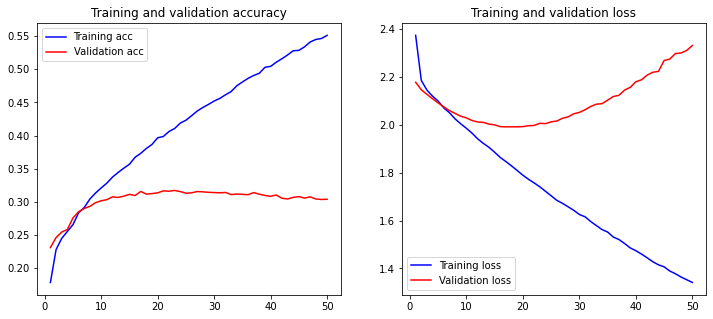

In [33]:
plot_history(history)

In [ ]:
y_predicted = model.predict(X_test)
accuracy = model.evaluate(X_test, y_test, batch_size= 100, verbose= True)


## Test avec un jeu plus filtré

In [62]:
# Lecture du fichiern et création de la data frame.
#  Nom des colonnes: tweet_id, sentiment, author, content
#  Liste des sentiments : 'empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
#    'hate' 'happiness' 'boredom' 'relief' 'anger'

data_emo2= pds.read_csv('./datas/text_emotion_02.csv')
#, engine= "python", encoding='utf-8', error_bad_lines=False) # POUR GOOGLE COLAB SINON ERREUR!

print("Nombre de message:",len(data_emo2))

df_count_emotion = data_emo2.groupby(['sentiment']).size().reset_index(name='compt')
print("Les émotions....:\n",df_count_emotion)

df_count_author = data_emo2.groupby(['author']).size().reset_index(name='compt')
#print(df_count_author)
print("Les auteurs par ordres décroissant du nombre de message postés:\n",
      df_count_author.sort_values(by= "compt", ascending = False).head(30))


Nombre de message: 40000
Les émotions....:
      sentiment  compt
0        anger    110
1      boredom    179
2        empty    827
3   enthusiasm    759
4          fun   1776
5    happiness   5209
6         hate   1323
7         love   3842
8      neutral   8638
9       relief   1526
10     sadness   5165
11    surprise   2187
12       worry   8459
Les auteurs par ordres décroissant du nombre de message postés:
                 author  compt
7942       MissxMarisa     23
2171      ChineseLearn     22
7668    MiDesfileNegro     19
18330       erkagarcia     19
24210         lost_dog     18
32187         tsarnick     17
6093        KimmiMcfly     15
23944      linnetwoods     15
3079           Dogbook     14
15739      cece_newnew     14
26091  mrs_mcsupergirl     14
32248       twebbstack     14
9312             Quimo     14
21495  jesssicababesss     13
17396    divxdownloads     13
24184     lopezwilfred     12
11650     TraceyHewins     12
23713        lesley007     12
11577        

In [63]:
# Tokenisation

# Création d'une colonne tokenisée
corpus=[]
for el in data_emo2.content:
    token= word_tokenize(el)
    corpus.append(token)
data_emo2['token_brut'] = pds.Series(corpus)
#print(data_emo2.token_brut.head(10))

In [64]:

X_train, X_test, y_train, y_test = train_test_split(data_emo2.token_brut, data_emo2.sentiment, test_size = 0.3,random_state=42)


num_words= 5000
tokenizer = Tokenizer(num_words= num_words, lower= False, filters= '')
tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(X_train_we[2])
print(X_test_we[2])
print(vocab_size)

[2, 62, 16, 32, 32]
[3008, 436, 400, 3052, 258, 3052, 2927, 337, 53, 1668, 6, 34, 20, 1]
45997


In [65]:

maxlen = 100

X_train_ps = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_test_ps = pad_sequences(X_test_token, padding='post', maxlen=maxlen)

In [66]:

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           2299850   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_16 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_17 (Dense)             (None, 13)                1313      
Total params: 2,302,773
Trainable params: 2,302,773
Non-trainable params: 0
_________________________________________________________________


In [67]:

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [68]:
history = model.fit(X_train_ps, y_train,
                    epochs=10,
                    verbose= True,
                    validation_data=(X_test_ps, y_test),
                    batch_size=200)
loss, accuracy = model.evaluate(X_train_ps, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_ps, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Epoch 1/10
140/140 [==============================] - 4s 27ms/step - loss: 2.3540 - accuracy: 0.1905 - val_loss: 2.1417 - val_accuracy: 0.2648
Epoch 2/10
140/140 [==============================] - 4s 31ms/step - loss: 2.1189 - accuracy: 0.2664 - val_loss: 1.9848 - val_accuracy: 0.3194
Epoch 3/10
140/140 [==============================] - 5s 39ms/step - loss: 1.9141 - accuracy: 0.3481 - val_loss: 1.9336 - val_accuracy: 0.3351
Epoch 4/10
140/140 [==============================] - 5s 39ms/step - loss: 1.7921 - accuracy: 0.3805 - val_loss: 1.9316 - val_accuracy: 0.3363
Epoch 5/10
140/140 [==============================] - 5s 39ms/step - loss: 1.7144 - accuracy: 0.4154 - val_loss: 1.9492 - val_accuracy: 0.3355
Epoch 6/10
140/140 [==============================] - 5s 38ms/step - loss: 1.6348 - accuracy: 0.4416 - val_loss: 1.9900 - val_accuracy: 0.3316
Epoch 7/10
140/140 [==============================] - 5s 38ms/step - loss: 1.5398 - accuracy: 0.4778 - val_loss: 2.0542 - val_accuracy: 0.3289

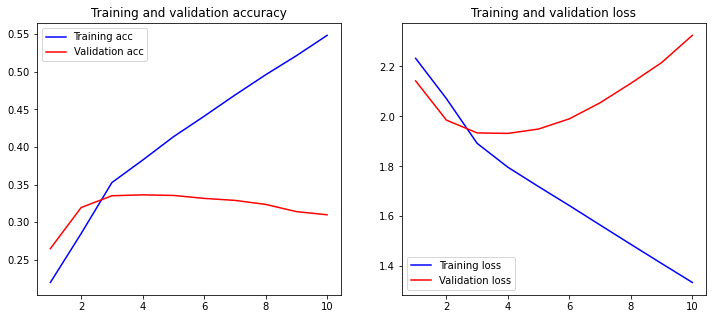

In [69]:
plot_history(history)

In [80]:
from copy import deepcopy
import re

test= deepcopy(data_emo2.content)

In [134]:
#print(tokenizer.word_index)

In [81]:
for el in test:
    pass
    #print(el)

SyntaxError: unexpected EOF while parsing (<ipython-input-81-ee878ee12268>, line 2)

True

In [107]:
ch= 'hlkjqdshl qds http://www.example.es/cat1/cat2/some-example_DH148439#.Rh1-js_4 lhlkj qs'
'hlkjqdshl qds http://www.example.es/cat1/cat2/some-example_DH148439#.Rh1-js_4 lhlkj qs'

True


In [124]:
text= 'hlkjqdshl qds https://www.example.es/cat1/cat2/some-example_DH148439#.Rh1-js_4 lhlkj qs'

In [125]:
ch = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

#p = re.compile(r'^[^:]+://([^.]+\.)+[^/]+/([^/]+/)+[^#]+(#.+)?$')



In [126]:
ch

'hlkjqdshl qds https://www.example.es/cat1/cat2/some-example_DH148439#.Rh1-js_4 lhlkj qs'

In [127]:
text

'hlkjqdshl qds https://www.example.es/cat1/cat2/some-example_DH148439#.Rh1-js_4 lhlkj qs'